# **Project: Vehicle Identification** 

---

 [![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)
 
 
 ## 1. Introduction
 
 The goal of this project is to develop classifier, which will be able to detect vehicles while driving using images from a dash cam. The vehicles should be identified correctly and performance should be sufficent to allow for  5-6 fps processing.
 
 One important assumption is the choice of algorithms used to identify cars on the road - in this project we use Computer Vision, especially Histogram of Oriented Gradients together with SVM based classification (SVC).
 
 This report is divided into following sections:
 * SVC model training
 * Features engineering
 * Image analysis
 * Video pipeline
 * Summary
 
 
 ## 2. SVC model training
 ### 2.1 Training data
 I decided to use only the datasets provided for this project - did not use the recently released dataset from Udacity.
 
 For each image, I extracted following features (see get_features in hog_utils.py for details):
 * color histogram
 * spatial features
 * HOG descriptor
 Those features will be used to train SVC classified
 
 ### 2.2 Train and test split
 I decided to have 20% of data in the test set. In case of GTI data, there was a problem pointed out in the course materials - some of the pictures were taken in series - there was the same car on them and differences were minimal. This means that in case of spreading such pictures between train and test set, they could disturb training process - classifier will "memorize" them and show better accuracy than with real data.
 
 To deal with this issue, I manually splitted the GTI sets - for each set i found a picture, which splitted the set with 80/20 rule but without spreading the same pictures across train and test set - see model_check in hog_utils.py for more details.
 
 All test and train data are scaled and shuffled before training
 
 ### 2.3 Training
 The SVC classifier is trained using default parameters and I calculated accuracy using test set. This allows me to comapre different models and select the one with best accuracy. An assumption about choosing accuracy as the metric for selecting model should be discussed in the future taking into account the requirements for the classifier.
 
 The classifier is trained using images with size 64x64 pixels, this means that any prediction must be made on image of the same size.
 ## 3 Feature engineering
 each feature has its parameters, which can impact the classifier accuracy, additionally selecting wrong parameters can result in bigger efatures and therefore longer processing time. To select best parameters I did the following:
* color histogram: I experimented manually setting different number of bins and decided to go with 32 bins
* spatial features  - I used similar procedure as in case of color histogram
* HOG has 3 omportant parameters and tuning them manually was too hard, especially with importance of color model selection. Therefore I decided to perform parameter searching.
### 3.1 Searching of parameter space
I made cartesian product of the possible parameter values and for each combination trained a calssifier, calculated its accuracy and features size. Trained classifier and scaler plus parameters used are stored together in a pickle for future use. Parameter values:
* HOG pixels per cell: 8, 12, 16
* HOG cells per block: 2, 3, 4
* HOG orientations: 6, 8, 9, 10, 12
* Color model: HLS and YCbCr - I made preselection using exploratory analysis

Above values gave me 90 combinations to check, here come the top 10 results:




In [4]:
%matplotlib inline
import cv2
from hog_utils import get_hog, color_hist, bin_spatial, slider, add_heat, apply_threshold, draw_labeled_bboxes, show3x1, show2x1
import pickle
from matplotlib import pyplot as plt
import numpy as np
from scipy.ndimage.measurements import label
import os
model_data = pickle.load(open('model_data.p', 'rb'))
import pandas as pd
from IPython.display import HTML

hog_space = pd.read_csv(open('hog_space.csv', 'r'), names=['pix_per_cell', 'cells_per_block', 'orientations', 'size',
                                                           'color_model', 'accuracy'], header = None)

In [5]:
top10 = hog_space.sort_values('accuracy', ascending = False)[0:9]
HTML(top10.to_html(index=False))


pix_per_cell,cells_per_block,orientations,size,color_model,accuracy
8,3,9,9612,HLS,0.991019
8,2,12,7920,YCbCr,0.990457
8,2,10,6744,YCbCr,0.989896
8,2,12,7920,HLS,0.989615
16,2,12,2160,HLS,0.989054
8,2,10,6744,HLS,0.989054
8,3,12,12528,HLS,0.989054
8,3,12,12528,YCbCr,0.988774
16,3,12,2160,HLS,0.988212


## 4. Image processing
### 4.1 Sliding window
I used slided window approach as described in project lectures. I developed a class named slider, which does the sliding window scan and makes predictions based on provided classifier. Slider class is initialized with:
* image to be processed
* area of interest - where to search for vehicles - these values were found by trial and error
* model - classifier, scaler plus parameters for features like HOG etc found during feature engineering
* step for sliding window found by trial and error
* scale: how to scale image before processing
The scale is used to make image smaller while keeping the same scan window size (64x64). This is similar approach to image pyramid method described by Adrian Rosenbrock, however I decided to use 2 sliders:
* 1:1 detecting objects with size 64x64,
* 1:2 detecting objects with size 128x128
An example of output is shown below, blue boxes are results of 128x128 scan.


In [55]:
img = cv2.imread('test_images/test1.jpg')
s0 = slider(img, (None, None), (300, 512), model = model_data, step = 8)
s1 = slider(img, (None, None), (350, None), model = model_data, scale = 1/2, step = 32)



Wall time: 16.2 s
Wall time: 395 ms


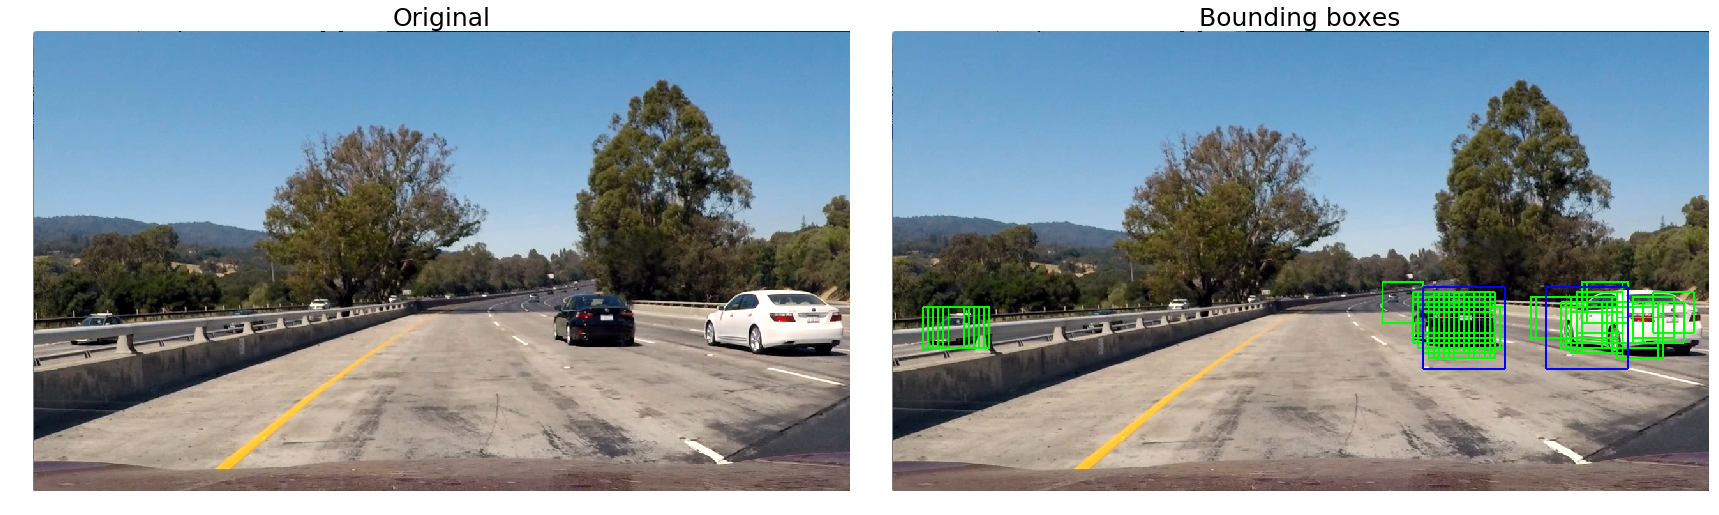

In [60]:
%time predict0 = s0.predict()


%time predict1 = s1.predict()

draw = img.copy()
for p1, p2 in predict0:
    cv2.rectangle(draw, p1, p2, (0, 255, 0), 2)

for p1, p2, in predict1:
    cv2.rectangle(draw, p1, p2, (255, 0, 0), 2)

draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
show2x1(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), draw, 'Original', 'Bounding boxes')


### 4.2 Heat maps

To deal with false positives, I implemented heatmap as described in lectures. For each images, I created a heatmpap containing points returned by the classifier, then apply threshold found by trual and error and perform labeling as described in the lectures. A bouding box is then drawn around found cars.

Result for test images is shown below:

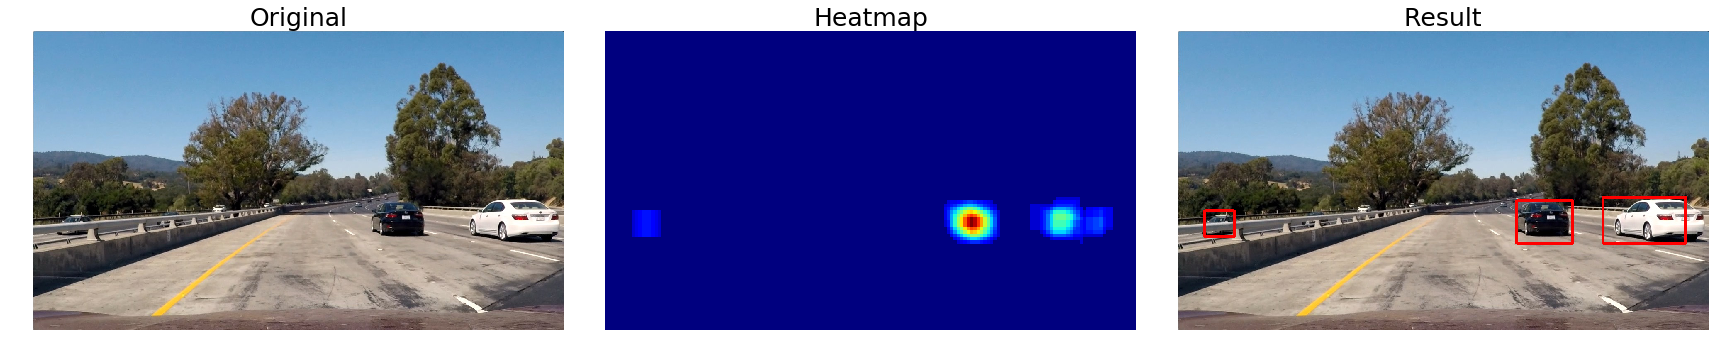

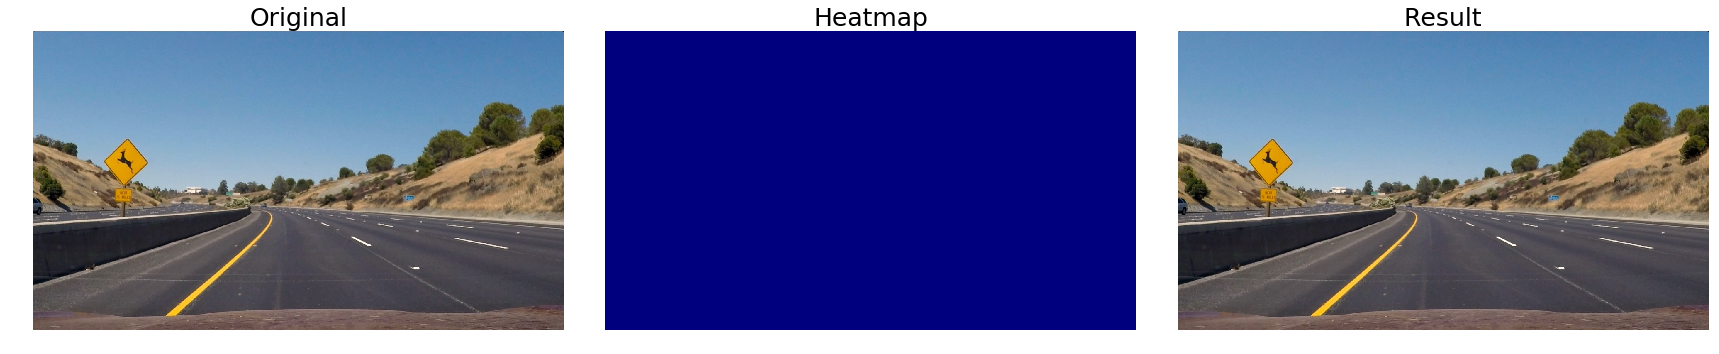

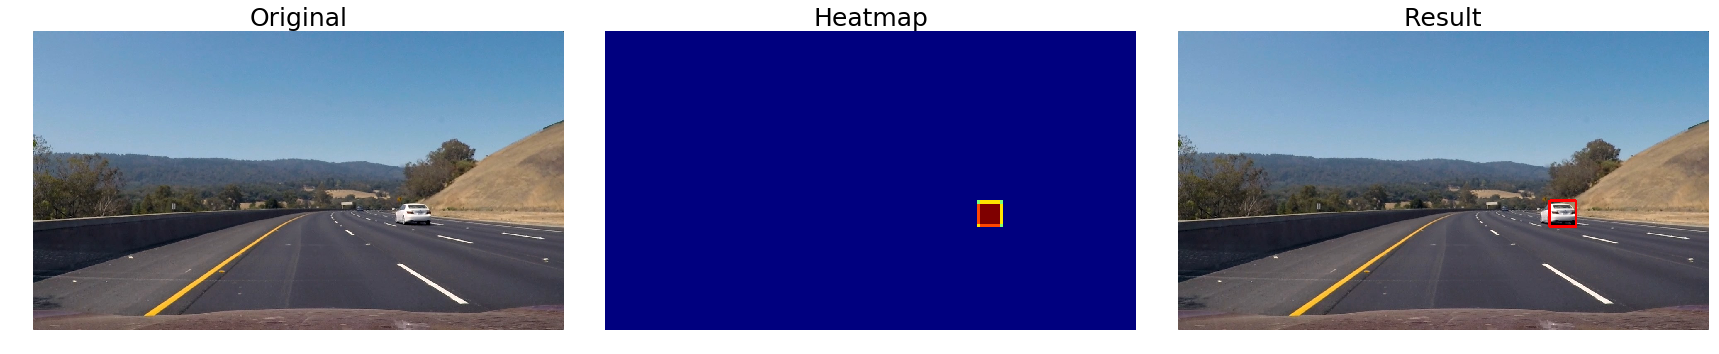

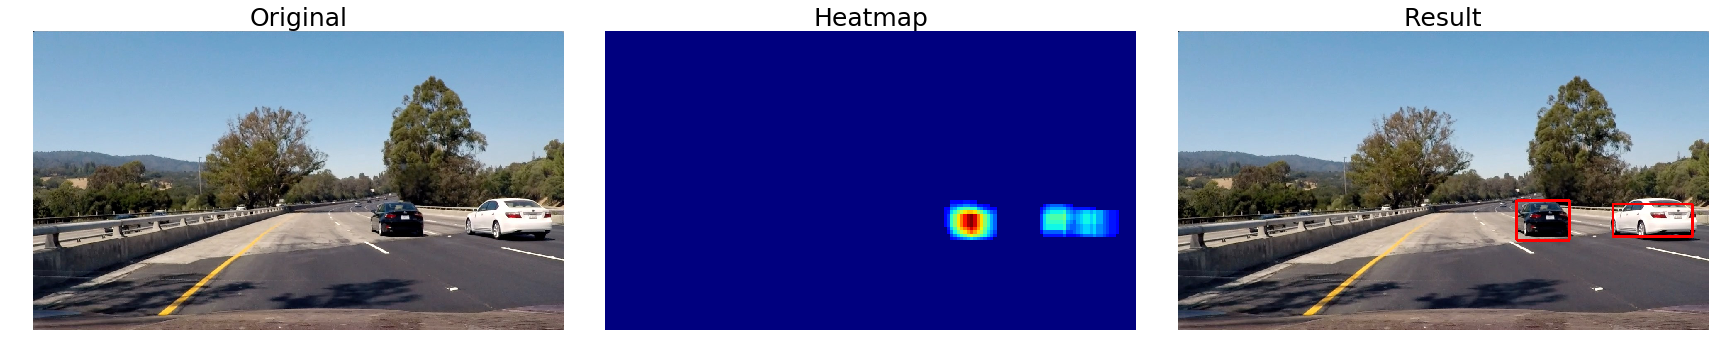

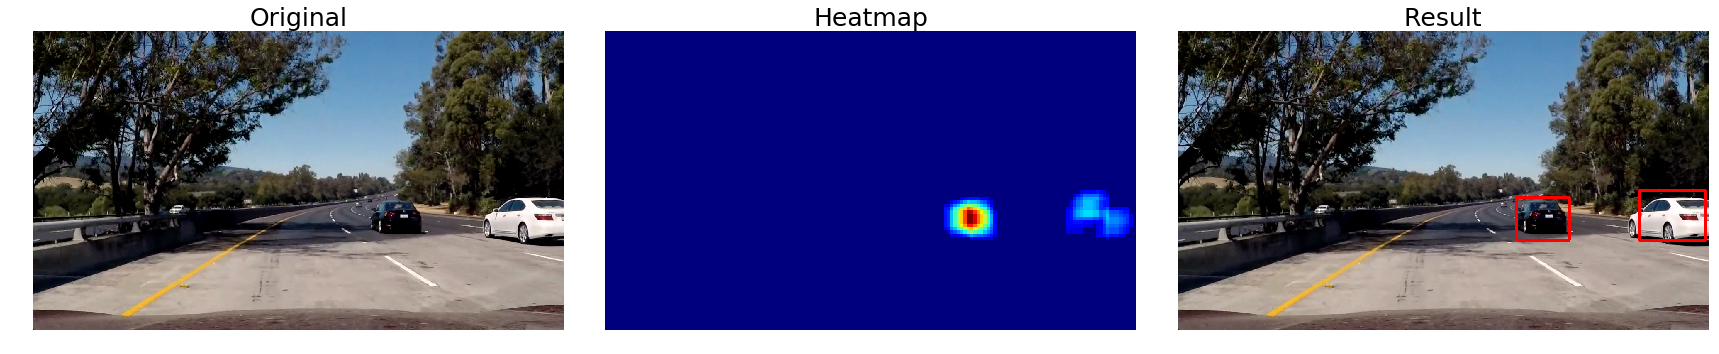

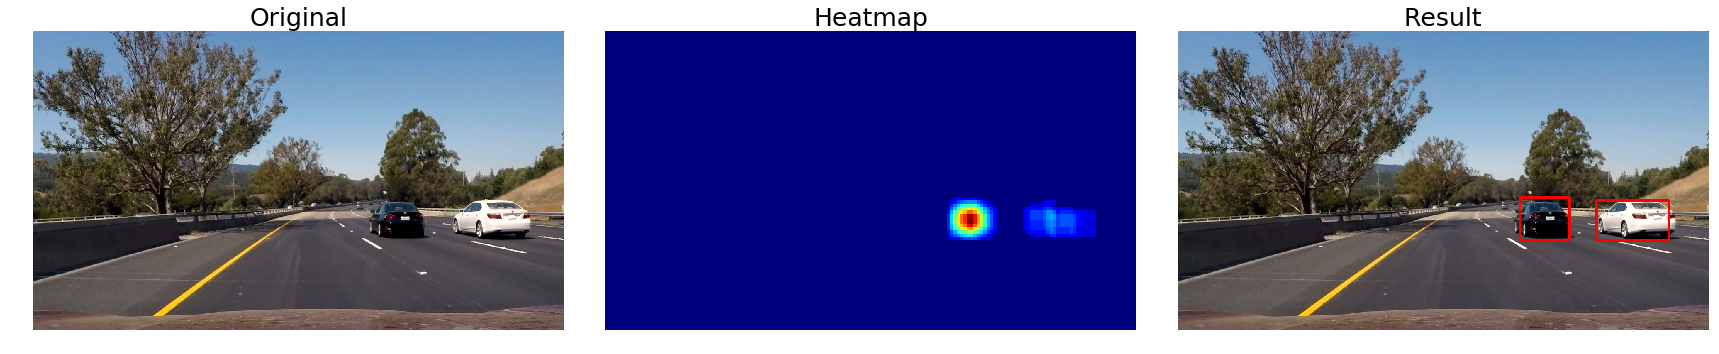

In [22]:
directory = 'test_images'
for f in os.listdir(directory):
    if f.endswith('.jpg'):
        img = cv2.imread(directory + '/' + f)
        s0 = slider(img, (None, None), (300, 512), model = model_data, step = 8)
        s1 = slider(img, (None, None), (350, None), model = model_data, scale = 1/2, step = 32)
        predict0 = s0.predict()
        predict1 = s1.predict()
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        heat = add_heat(heat, predict0)
        heat = add_heat(heat, predict1)
        heat = apply_threshold(heat, 2)
        labels = label(heat)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
        draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        show3x1(img, heat, draw_img, 'Original', 'Heatmap', 'Result')

## 5. Video pipeline

To process video file, I applied the all elements described in chapter "Image processing"  to each frame. Additionally I also run the lane finding code from Project 4 and draw its output.

Result is shown below, click on it for full version.

[![Result](result.gif)](result.mp4)

## 6. Summary and discussion
### 6.1 Classifier
My model reports very interesting false positives - i.e finds cars in the trees. Selecting areaof interest removes those false positives, however this signals a room for improvement here.

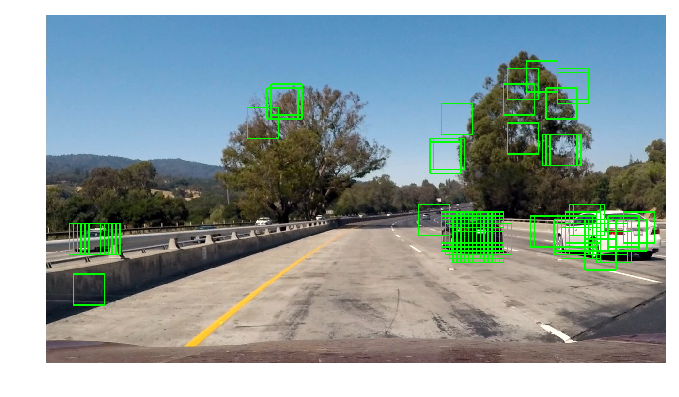

In [7]:
img = cv2.imread('test_images/test1.jpg')
s0 = slider(img, (None, None), (None, None), model = model_data, step = 8)
predict0 = s0.predict()
draw = img.copy()
for p1, p2 in predict0:
    cv2.rectangle(draw, p1, p2, (0, 255, 0), 2)
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.axis('off')
plt.imshow(draw)

The classifier shoud be retrained with more samples and also a hard-negative mining could be used to avoid false posives as described by Adrian Rosebrock [here](http://www.pyimagesearch.com/2014/11/10/histogram-oriented-gradients-object-detection/). Also some SVC specific tuning should be performed to ensure best results.
### 6.2 Parameters
The full video shows that a tradeoff between processing time and accuracy is far from being perfect. Especially number of sliding windows and area of interest should be reviewed to better detect vehicles coming into picture. Method of grouping multiple detections into one should be also changed to either [deformable parts model by Pedro F. Felzenszwalb et al](http://cs.brown.edu/~pff/papers/lsvm-pami.pdf) or [Exemplar SVMs by Tomasz Malisiewicz](http://cs.brown.edu/~pff/papers/lsvm-pami.pdf)

One of main outcomes of this project is its sensitiviness to parameter tuning. While I performed basic feature engineering, it should be repated to confirm my findings. The resulting parameter set should be atradeoff between accuracy and features size, because it impact the processing time.
### 6.3 Performance
My code is terribly slow - on Intel Core i5-5300  @ 2.30 GHz it processes one frame in 10 seconds, this is far below expectations of doing realtime identification. There are different ways of dealing with this problem:
* the calculations are done on 1 core, but switching to multicore algorithm should be considered as last resort options, because the code can be optimized
* HOG calculations are responsible for most of the time used for processing, so reducing this should be the first goal. There will be siginificant improvement in case of solution based on HOG subsampling or more general using Piotr Dollar's [paper](https://pdollar.github.io/files/papers/DollarBMVC10FPDW.pdf) 

### 6.4 Final thoughts
Car detection using Computer Vision and models like SVM requires a lot of feature engineering and model tuning, however final results should be good enough to contribute to the Self Driving Car systems responsible for environment mapping. There are other technologies available like U-net and others and final choice should be made on the tradeoff between accuracy (or other metrics) and computational power required for processing.

In [74]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import csv
from processor import FrameProcessor
fp = FrameProcessor()

def process_frame(img):
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    s0 = slider(img, (None, None), (300, 512), model = model_data, step = 8)
    s1 = slider(img, (None, None), (350, None), model = model_data, scale = 1/2, step = 32)
    predict0 = s0.predict()
    predict1 = s1.predict()
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, predict0)
    heat = add_heat(heat, predict1)
    heat = apply_threshold(heat, 2)
    labels = label(heat)
    draw_img = fp.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    draw_img = draw_labeled_bboxes(draw_img, labels)
    return draw_img

In [75]:


project_output = 'result.mp4'
clip1 = VideoFileClip("test_video.mp4");
white_clip = clip1.fl_image(process_frame) 
%time white_clip.write_videofile(project_output, audio=False);
with open('log.csv', 'w') as logfile:
    writer = csv.writer(logfile, delimiter = ';')
    writer.writerows(fp.log)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4



 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [10:08<00:16, 16.03s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

Wall time: 10min 10s


In [76]:
mini_clip = white_clip.subclip((0,0),(0, 5.0)).resize(0.4)
mini_clip.write_gif('result.gif', fps = 10)


[MoviePy] Building file result.gif with imageio



 98%|████████████████████████████████████████████████████████████████████████████████▍ | 50/51 [16:15<00:18, 18.98s/it]
